## sigMF IQ file SVD reconstruction: PTT analog

In [42]:
import os
import torch #, torchvision
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from torch import istft
global GPU, n_fft
GPU = 1
Fs = 1e6
n_fft = 1000
plt.style.use('default')
device = torch.device('cuda:1')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:1
Is cuda available? = True


In [2]:
# %matplotlib notebook
# %matplotlib inline

#### Machine paths

In [2]:
path = "/home/david/sigMF_ML/RF_SVD/UDV_matrix/PTT_UDV/"
os.chdir(path)
print(path)

/home/david/sigMF_ML/RF_SVD/UDV_matrix/PTT_UDV/


In [3]:
db = np.fromfile("UHF_NFM_UV5R_clean1.sigmf-data", dtype="float32")

#### torch GPU Cuda stft

In [4]:
def gpu(db):
    I = db[0::2]
    Q = db[1::2]
    start = timer()
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=True)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    end = timer()
    gpu_stft_time = end - start
    print('GPU STFT time = ', gpu_stft_time)
    torch.cuda.empty_cache()
    return I_stft, Q_stft, gpu_stft_time

#### FOR plotting spectrum: one sided must be false on torch.stft

In [5]:
def gpu_plot(db):
    I = db[0::2]
    Q = db[1::2]
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
    X_stft = torch.cat((X_stft[n_fft//2:],X_stft[:n_fft//2]))
    torch.cuda.empty_cache()
    return X_stft

#### scipy CPU stft function for reference

In [6]:
def cpu(db):
    t = len(db)
    db2 = db[0::]
    start = timer()
    db = db.astype(np.float32).view(np.complex64)
    I_t, I_f, Z = signal.stft(db, fs=Fs, nperseg=n_fft, return_onesided=False)
    Z = np.vstack([Z[n_fft//2:], Z[:n_fft//2]])
    end = timer()
    cpu_stft_time = end - start
    print('CPU STFT time = ', cpu_stft_time)
    return Z, cpu_stft_time

### GPU Timing: first time slowest

In [7]:
stft_gpu = gpu_plot(db)

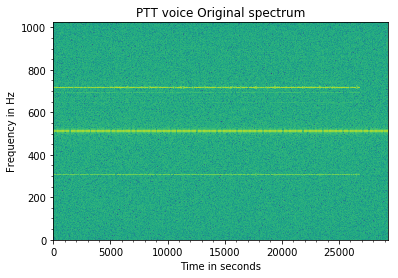

In [8]:
plt.figure(figsize=(9, 6))
fig3 = plt.figure()
plt.imshow(20*np.log10(np.abs(stft_gpu.cpu()+1e-8)), aspect='auto', origin='lower')
title = "PTT voice Original spectrum"
plt.title(title)
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')
plt.minorticks_on()
# plt.yticks(np.arange(0,60, 6))
fig3.savefig('ptt_full_spectrum.pdf', format="pdf")
plt.show()

#### GPU SVD

In [9]:
def udv_stft(I_stft,Q_stft):
    start = timer()
    U_I0, D_I0, V_I0 = torch.svd(I_stft[...,0].detach().cpu()) 
    U_I1, D_I1, V_I1 = torch.svd(I_stft[...,1].detach().cpu()) 
    U_Q0, D_Q0, V_Q0 = torch.svd(Q_stft[...,0].detach().cpu()) 
    U_Q1, D_Q1, V_Q1 = torch.svd(Q_stft[...,1].detach().cpu()) 
    end = timer()
    usv_stft_time = end - start
    print('SVD time: ',usv_stft_time)
    return U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1, usv_stft_time

#### Inverse stft 

In [10]:
def ISTFT(db):
    w = n_fft
    win = torch.hann_window(w, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    start = timer()
    Z = istft(db, n_fft=n_fft, hop_length=n_fft//2, win_length=w, window=win, center=True, normalized=True, onesided=True)
    end = timer()
    istft_time = end - start
    print('ISTFT time = ',istft_time)
    torch.cuda.empty_cache()
    return Z, istft_time

#### Re-combine UDV to approximate original signal

In [11]:
def udv(u, d, v, k):
#     print('u shape = ', u.shape)
#     print('d shape = ', d.shape)
#     print('v shape = ', v.shape)
    start = timer()
    UD = torch.mul(u[:, :k], d[:k])
    print('UD shape = ', UD.shape)
    v = torch.transpose(v,1,0)
    UDV = torch.mm(UD, v[:k, :])
    end = timer()
    udv_time = end - start
#     print('u new shape = ', u[:, :k].shape)
#     print('d new shape = ', d[:k].shape)
#     print('v new shape = ', v[:k, :].shape)
    print('UDV time: ',udv_time)
    return UDV, udv_time

In [12]:
def udv_from_file(u, d, v):
    start = timer()
#     print('u shape = ', u.shape)
#     print('d shape = ', d.shape)
#     print('v shape = ', v.shape)
    UD = torch.mul(u[:, :], d[:])
#     print('UD shape = ', UD.shape)
    v = torch.transpose(v,1,0)
    UDV = torch.mm(UD, v[:, :])
    end = timer()
    udv_time = end - start
    print('UDV time: ',udv_time)
    return UDV, udv_time

### Main function to run all sub function calls

In [13]:
def complete_gpu(num):
    I_stft, Q_stft, gpu_stft_time = gpu(db)
    U_I0, D_I0, V_I0, U_I1, D_I1, V_I1, U_Q0, D_Q0, V_Q0, U_Q1, D_Q1, V_Q1, udv_time = udv_stft(I_stft,Q_stft)
    torch.cuda.empty_cache()
    print('UDV I0 shapes = ',U_I0.shape, D_I0.shape, V_I0.shape)
    print('UDV I1 shapes = ',U_I1.shape, D_I1.shape, V_I1.shape)
    print('UDV Q0 shapes = ', U_Q0.shape, D_Q0.shape, V_Q0.shape)
    print('UDV Q1 shapes = ', U_Q1.shape, D_Q1.shape, V_Q1.shape)
    # ------------ I0 ------------------------------------------------------
    np.save('U_I0', U_I0[:, :num].detach().cpu().numpy())
    np.save('D_I0', D_I0[:num].detach().cpu().numpy())
    np.save('V_I0', V_I0[:, :num].detach().cpu().numpy())
#     print('saved V_IO size = ', V_I0[:, :num].shape)
    # ------------ I1 ------------------------------------------------------
    np.save('U_I1', U_I1[:, :num].detach().cpu().numpy())
    np.save('D_I1', D_I1[:num].detach().cpu().numpy())
    np.save('V_I1', V_I1[:, :num].detach().cpu().numpy())
#     print('saved V_I1 size = ', V_I1[:, :num].shape)
    # ------------ Q0 ------------------------------------------------------
    np.save('U_Q0', U_Q0[:, :num].detach().cpu().numpy())
    np.save('D_Q0', D_Q0[:num].detach().cpu().numpy())
    np.save('V_Q0', V_Q0[:, :num].detach().cpu().numpy()) 
#     print('saved V_QO size = ', V_Q0[:, :num].shape)
    # ------------ Q1 ------------------------------------------------------
    np.save('U_Q1', U_Q1[:, :num].detach().cpu().numpy())
    np.save('D_Q1', D_Q1[:num].detach().cpu().numpy())
    np.save('V_Q1', V_Q1[:, :num].detach().cpu().numpy())    
#     print('saved V_Q1 size = ', V_Q1[:, :num].shape)
    # -----------------------------------------------------------------------
    udv_I0, udv_time1 = udv(U_I0, D_I0, V_I0,num)
    udv_I1, udv_time2 = udv(U_I1, D_I1, V_I1,num)
    udv_Q0, udv_time3 = udv(U_Q0, D_Q0, V_Q0,num)
    udv_Q1, udv_time4 = udv(U_Q1, D_Q1, V_Q1,num)
    torch.cuda.empty_cache()
    print('udv I shapes = ',udv_I0.shape,udv_I1.shape)
    print('udv Q shapes = ',udv_Q0.shape,udv_Q1.shape)
    # -------------stack and transpose----------------------------------------
    start_misc = timer()
    UDV_I = torch.stack([udv_I0,udv_I1])
    UDV_I = torch.transpose(UDV_I,2,0)
    UDV_I = torch.transpose(UDV_I,1,0)
    UDV_Q = torch.stack([udv_Q0,udv_Q1])
    UDV_Q = torch.transpose(UDV_Q,2,0)
    UDV_Q = torch.transpose(UDV_Q,1,0)
    stop_misc = timer()
    misc_time = stop_misc - start_misc
    torch.cuda.empty_cache()
    #--------------------------------------------------------------------------
    I, istft_time1 = ISTFT(UDV_I.cuda(GPU))
    Q, istft_time2 = ISTFT(UDV_Q.cuda(GPU))
    torch.cuda.empty_cache()
    I = I.detach().cpu().numpy()
    Q = Q.detach().cpu().numpy()
    end = len(I)*2
    IQ_SVD = np.zeros(len(I)*2) # I and Q must be same length
    IQ_SVD[0:end:2] = I
    IQ_SVD[1:end:2] = Q 
    time_sum = gpu_stft_time+udv_time+misc_time+udv_time1+udv_time2+udv_time3+udv_time4+istft_time1+istft_time2
    IQ_SVD = IQ_SVD.astype(np.float32).view(np.complex64)
    return IQ_SVD, time_sum

In [14]:
torch.cuda.empty_cache()

### Perform SVD on IQ stft data

In [67]:
num = 10 # number to reconstruct SVD matrix from
IQ_SVD, time_sum = complete_gpu(num)

GPU STFT time =  0.05690017296001315
SVD time:  2.3650257499539293
UDV I0 shapes =  torch.Size([501, 501]) torch.Size([501]) torch.Size([30001, 501])
UDV I1 shapes =  torch.Size([501, 501]) torch.Size([501]) torch.Size([30001, 501])
UDV Q0 shapes =  torch.Size([501, 501]) torch.Size([501]) torch.Size([30001, 501])
UDV Q1 shapes =  torch.Size([501, 501]) torch.Size([501]) torch.Size([30001, 501])
UD shape =  torch.Size([501, 10])
UDV time:  0.006632657954469323
UD shape =  torch.Size([501, 10])
UDV time:  0.006549775949679315
UD shape =  torch.Size([501, 10])
UDV time:  0.008880141016561538
UD shape =  torch.Size([501, 10])
UDV time:  0.005707553005777299
udv I shapes =  torch.Size([501, 30001]) torch.Size([501, 30001])
udv Q shapes =  torch.Size([501, 30001]) torch.Size([501, 30001])
ISTFT time =  0.018877675000112504
ISTFT time =  0.018234573013614863


In [68]:
time_sum # double sided = true, GPU stft/istft, CPU svd (torch)

2.498902181861922

### Write reconstructed IQ file to file

In [69]:
from array import array
IQ_file = open("ptt_svd10_1k_fft", 'wb')
IQ_SVD.tofile(IQ_file)
IQ_file.close()

#### load arrays for reconstruction

In [21]:
def udv_file_reconstruct():    
    # ****** D **************
    D_I0 = np.load('D_I0.npy')
    D_I1 = np.load('D_I1.npy')
    D_Q0 = np.load('D_Q0.npy')
    D_Q1 = np.load('D_Q1.npy')
    # ****** U **************
    U_I0 = np.load('U_I0.npy')
    U_I1 = np.load('U_I1.npy')
    U_Q0 = np.load('U_Q0.npy')
    U_Q1 = np.load('U_Q1.npy')
    # ****** V **************
    V_I0 = np.load('V_I0.npy')
    V_I1 = np.load('V_I1.npy')
    V_Q0 = np.load('V_Q0.npy')
    V_Q1 = np.load('V_Q1.npy')
    # ****** d to torch **************
    d_i0 = torch.tensor(D_I0).cuda(GPU)
    d_i1 = torch.tensor(D_I1).cuda(GPU)
    d_q0 = torch.tensor(D_Q0).cuda(GPU)
    d_q1 = torch.tensor(D_Q1).cuda(GPU)
    # ****** u to torch **************
    u_i0 = torch.tensor(U_I0).cuda(GPU)
    u_i1 = torch.tensor(U_I1).cuda(GPU)
    u_q0 = torch.tensor(U_Q0).cuda(GPU)
    u_q1 = torch.tensor(U_Q1).cuda(GPU)
    # ****** v to torch **************
    v_i0 = torch.tensor(V_I0).cuda(GPU)
    v_i1 = torch.tensor(V_I1).cuda(GPU)
    v_q0 = torch.tensor(V_Q0).cuda(GPU)
    v_q1 = torch.tensor(V_Q1).cuda(GPU)
    # ****** reconstruction *********************
    udv_I0, udv_time1 = udv_from_file(u_i0, d_i0, v_i0)
    udv_I1, udv_time2 = udv_from_file(u_i1, d_i1, v_i1)
    udv_Q0, udv_time3 = udv_from_file(u_q0, d_q0, v_q0)
    udv_Q1, udv_time4 = udv_from_file(u_q1, d_q1, v_q1)
    torch.cuda.empty_cache()
    print('udv I shapes = ',udv_I0.shape,udv_I1.shape)
    print('udv Q shapes = ',udv_Q0.shape,udv_Q1.shape)
    # -------------stack and transpose----------------------------------------
    start_misc = timer()
    UDV_I = torch.stack([udv_I0,udv_I1])
    UDV_I = torch.transpose(UDV_I,2,0)
    UDV_I = torch.transpose(UDV_I,1,0)
    UDV_Q = torch.stack([udv_Q0,udv_Q1])
    UDV_Q = torch.transpose(UDV_Q,2,0)
    UDV_Q = torch.transpose(UDV_Q,1,0)
    stop_misc = timer()
    misc_time = stop_misc - start_misc
    torch.cuda.empty_cache()
    #--------------------------------------------------------------------------
    I, istft_time1 = ISTFT(UDV_I)
    Q, istft_time2 = ISTFT(UDV_Q)
    torch.cuda.empty_cache()
    I = I.detach().cpu().numpy()
    Q = Q.detach().cpu().numpy()
    end = len(I)*2
    IQ_SVD = np.zeros(len(I)*2) # I and Q must be same length
    IQ_SVD[0:end:2] = I
    IQ_SVD[1:end:2] = Q 
    time_sum = misc_time+udv_time1+udv_time2+udv_time3+udv_time4+istft_time1+istft_time2
    IQ_SVD = IQ_SVD.astype(np.float32).view(np.complex64)
    torch.cuda.empty_cache()
    return IQ_SVD, time_sum

In [22]:
IQ_SVD2, time_sum2 = udv_file_reconstruct()

UDV time:  0.001200208999989627
UDV time:  0.000400549999994837
UDV time:  0.00018485700002202066
UDV time:  0.00017348400001537811
udv I shapes =  torch.Size([513, 29297]) torch.Size([513, 29297])
udv Q shapes =  torch.Size([513, 29297]) torch.Size([513, 29297])
ISTFT time =  0.019782933999977104
ISTFT time =  0.020234322000078464


In [23]:
time_sum2

0.04490164100002403

In [24]:
from array import array
IQ_file = open("ptt_svd10_recon", 'wb')
IQ_SVD2.tofile(IQ_file)
IQ_file.close()